In [9]:
import yfinance as yf
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, round as spark_round
from pyspark.sql.window import Window
import os

# 環境変数設定（重要: WindowsのSparkでParquet書き込み対策）
try:
    import env_setup
except ImportError:
    pass  # なければ無視

In [10]:
spark = SparkSession.builder \
    .appName("LoadParquetExample") \
    .master("local[*]") \
    .getOrCreate()

In [11]:
import os 
os.getcwd()

os.listdir()


['.ipynb_checkpoints',
 'env_setup.py',
 'process_prices.py',
 'stock_price_analysis.ipynb',
 'test.py',
 'test_notebook.ipynb',
 '__pycache__']

In [12]:
os.path.exists("../data/processed/stock_prices.parquet")


True

In [13]:
spark_df = spark.read.parquet("../data/processed/stock_prices.parquet")
spark_df.groupBy("Ticker").avg("Return(%)").show()


+------+--------------------+
|Ticker|      avg(Return(%))|
+------+--------------------+
| VOD.L|-0.05571347678369184|
|HSBA.L|0.014597961494903756|
|  BP.L|0.005158550396376...|
+------+--------------------+



In [14]:
spark_df.show(5)

+-------------------+------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+-----------------+---------+
|               Date|Ticker|             Open|             High|              Low|            Close|        Adj Close|  Volume|       Prev_Close|Return(%)|
+-------------------+------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+-----------------+---------+
|2018-01-02 00:00:00|  BP.L|524.2000122070312|524.2999877929688|514.2999877929688|            517.5|515.2674560546875|20152548|             null|     null|
|2018-01-03 00:00:00|  BP.L|519.2000122070312|525.5999755859375|518.7999877929688|524.2000122070312|521.9384155273438|27207749|            517.5|     1.29|
|2018-01-04 00:00:00|  BP.L|529.0999755859375|530.5999755859375|527.2000122070312|            530.0|527.7135620117188|32592520|524.2000122070312|     1.11|
|2018-01-05 00:00:00|  BP.L|            530.0|531.2999877929688|

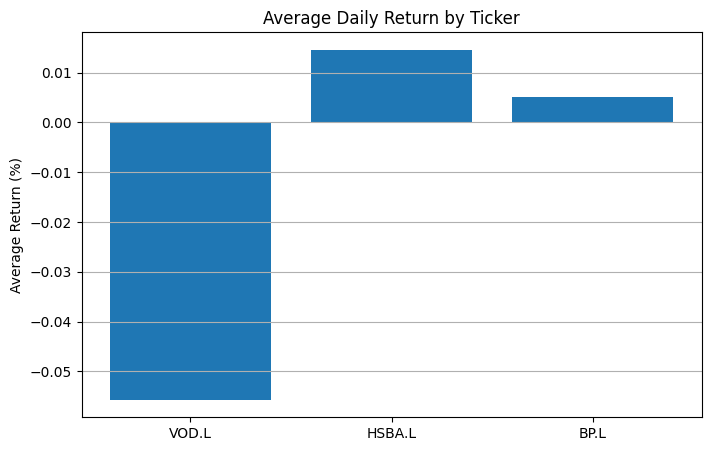

In [15]:
import matplotlib.pyplot as plt

# Step 1: Collect average returns by Ticker
avg_returns = spark_df.groupBy("Ticker").avg("Return(%)").toPandas()

# Step 2: Rename column for clarity
avg_returns.columns = ["Ticker", "Average Return (%)"]

# Step 3: Plot
plt.figure(figsize=(8, 5))
plt.bar(avg_returns["Ticker"], avg_returns["Average Return (%)"])
plt.title("Average Daily Return by Ticker")
plt.ylabel("Average Return (%)")
plt.grid(axis="y")
plt.show()

In [16]:
avg_returns

,Ticker,Average Return (%)
0,VOD.L,-0.055713
1,HSBA.L,0.014598
2,BP.L,0.005159


In [18]:
df_pd = spark_df.toPandas()
df_vod = df_pd[df_pd['Ticker'] == 'VOD.L']
df_vod

c:\Users\Pupi\Desktop\Git project\stock-trend-etl-spark\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Return(%)
3534,2018-01-02,VOD.L,235.149994,235.300003,233.100006,233.800003,232.580856,28518111,NaN,NaN
3535,2018-01-03,VOD.L,234.399994,234.399994,232.050003,233.449997,232.232651,36335155,233.800003,-0.15
3536,2018-01-04,VOD.L,234.250000,235.300003,233.000000,235.300003,234.073044,65362950,233.449997,0.79
3537,2018-01-05,VOD.L,236.000000,236.899994,234.699997,236.800003,235.565186,69338309,235.300003,0.64
3538,2018-01-08,VOD.L,236.600006,238.800003,236.250000,237.649994,236.410767,58835938,236.800003,0.36
...,...,...,...,...,...,...,...,...,...,...
5296,2024-12-20,VOD.L,66.839996,66.940002,66.120003,66.500000,66.480278,153387989,67.059998,-0.84
5297,2024-12-23,VOD.L,66.919998,66.919998,66.279999,66.480003,66.460289,63293094,66.500000,-0.03
5298,2024-12-24,VOD.L,66.800003,67.940002,66.620003,67.760002,67.739906,27798312,66.480003,1.93
5299,2024-12-27,VOD.L,67.519997,67.959999,66.800003,67.339996,67.320030,60270857,67.760002,-0.62


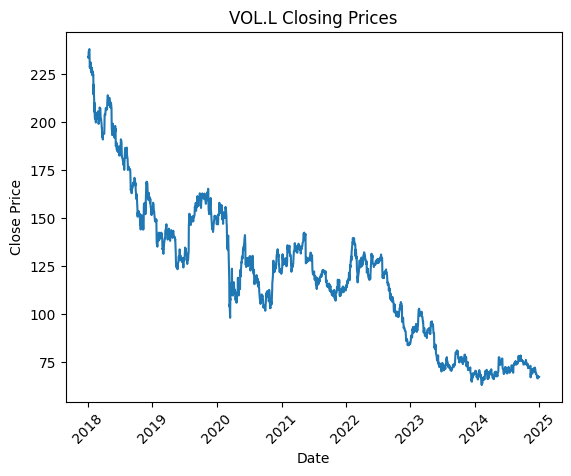

In [19]:
import matplotlib.pyplot as plt
plt.plot(df_vod['Date'], df_vod['Close'])
plt.title('VOL.L Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.show()

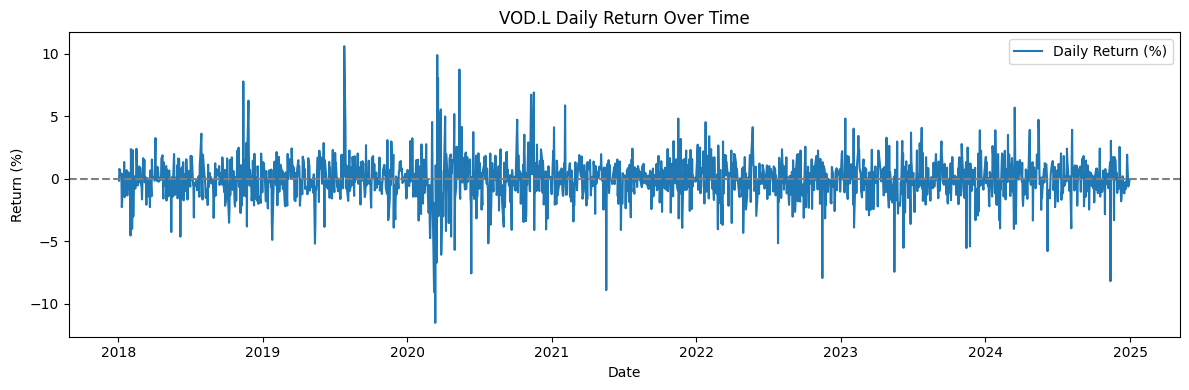

In [20]:
# Plot return over time
plt.figure(figsize=(12, 4))
plt.plot(df_vod["Date"], df_vod["Return(%)"], label="Daily Return (%)")
plt.title("VOD.L Daily Return Over Time")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

I've noticed large positive spikes before 2020. On the other hand, there are negative spikes after 2020. This suggests that COVID-19 may have affected VOD.L's stock price.

In [21]:
df_pd['Normalized_Close'] = df_pd.groupby('Ticker')['Close'].transform(lambda x: x)
df_pd


,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Return(%),Normalized_Close
0,2018-01-02,BP.L,524.200012,524.299988,514.299988,517.500000,515.267456,20152548,NaN,NaN,517.500000
1,2018-01-03,BP.L,519.200012,525.599976,518.799988,524.200012,521.938416,27207749,517.500000,1.29,524.200012
2,2018-01-04,BP.L,529.099976,530.599976,527.200012,530.000000,527.713562,32592520,524.200012,1.11,530.000000
3,2018-01-05,BP.L,530.000000,531.299988,526.700012,529.599976,527.315308,24779506,530.000000,-0.08,529.599976
4,2018-01-08,BP.L,529.400024,530.299988,526.900024,527.400024,525.124695,29326873,529.599976,-0.42,527.400024
...,...,...,...,...,...,...,...,...,...,...,...
5296,2024-12-20,VOD.L,66.839996,66.940002,66.120003,66.500000,66.480278,153387989,67.059998,-0.84,66.500000
5297,2024-12-23,VOD.L,66.919998,66.919998,66.279999,66.480003,66.460289,63293094,66.500000,-0.03,66.480003
5298,2024-12-24,VOD.L,66.800003,67.940002,66.620003,67.760002,67.739906,27798312,66.480003,1.93,67.760002
5299,2024-12-27,VOD.L,67.519997,67.959999,66.800003,67.339996,67.320030,60270857,67.760002,-0.62,67.339996


In [22]:
df_pd = df_pd.sort_values(['Ticker', 'Date'])
df_pd['Normalized_Close'] = df_pd.groupby('Ticker')['Close'].transform(lambda x: x / x.iloc[0])


In [23]:
df_pd.head()

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Return(%),Normalized_Close
0,2018-01-02,BP.L,524.200012,524.299988,514.299988,517.500000,515.267456,20152548,NaN,NaN,1.000000
1,2018-01-03,BP.L,519.200012,525.599976,518.799988,524.200012,521.938416,27207749,517.500000,1.29,1.012947
2,2018-01-04,BP.L,529.099976,530.599976,527.200012,530.000000,527.713562,32592520,524.200012,1.11,1.024155
3,2018-01-05,BP.L,530.000000,531.299988,526.700012,529.599976,527.315308,24779506,530.000000,-0.08,1.023382
4,2018-01-08,BP.L,529.400024,530.299988,526.900024,527.400024,525.124695,29326873,529.599976,-0.42,1.019130


In [24]:
import seaborn as sns


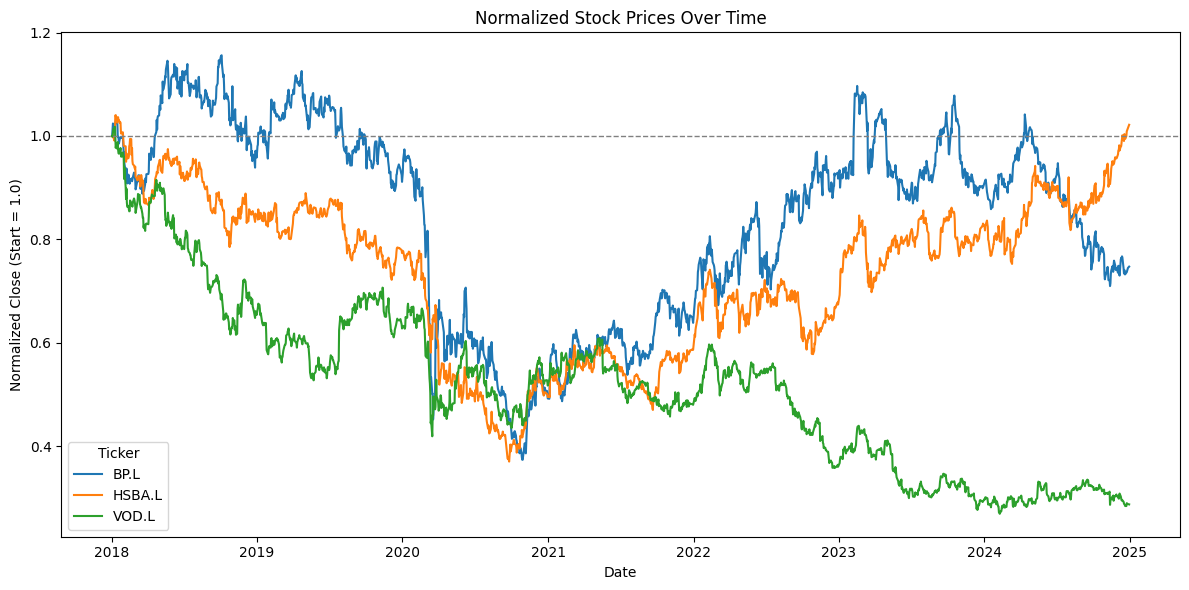

In [25]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pd, x="Date", y="Normalized_Close", hue="Ticker")
plt.title("Normalized Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Close (Start = 1.0)")
plt.axhline(1, color="gray", linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()

In [29]:
df_pd.columns
df_pd.groupby("Ticker")["Return(%)"].rolling(30).std()


Ticker      
BP.L    0            NaN
        1            NaN
        2            NaN
        3            NaN
        4            NaN
                  ...   
VOD.L   5296    2.000689
        5297    1.979030
        5298    1.348288
        5299    1.228247
        5300    1.225324
Name: Return(%), Length: 5301, dtype: float64

In [30]:
df_pd["Volatility(30d)"] = df_pd.groupby("Ticker")["Return(%)"].transform(
    lambda x: x.rolling(window=30).std()
)

In [37]:
df_pd.groupby('Ticker')["Volatility(30d)"].mean()

Ticker
BP.L      1.872375
HSBA.L    1.534368
VOD.L     1.633318
Name: Volatility(30d), dtype: float64

It probably means that BP.L is more volatile and influenced by external factors in the energy sector.

In [38]:
df_pd["RollingAvg_Return"] = df_pd.groupby("Ticker")["Return(%)"].transform(
    lambda x: x.rolling(window=30).mean()
)

In [39]:
df_pd.groupby('Ticker')["RollingAvg_Return"].mean()

Ticker
BP.L      0.005781
HSBA.L    0.012080
VOD.L    -0.052308
Name: RollingAvg_Return, dtype: float64

Based on this outcome, only VOD.L has a negative average, which suggests that its 30-day returns have been more frequently negative than positive over the observed period.g